<a href="https://colab.research.google.com/github/jwkanggist/EverybodyTensorflow2.0/blob/master/lab24_basic_bilstm_timepredict_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB24: Basic BiLSTM to Predict Time Series
- Train a basic BiLSTM to predict a time series (seq2seq)



In [0]:
# preprocessor parts
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


In [0]:
 # for Tensorboard use
  LOG_DIR = 'drive/data/tb_logs'
	
  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  !unzip ngrok-stable-linux-amd64.zip
	
  import os
  if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)
	  
  get_ipython().system_raw(
      'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
      .format(LOG_DIR))
	
  get_ipython().system_raw('./ngrok http 6006 &')
	
  !curl -s http://localhost:4040/api/tunnels | python3 -c \
      "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-01-18 18:19:50--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.235.253.190, 3.234.122.223, 34.202.58.243, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.235.253.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  39.0MB/s    in 0.3s    

2020-01-18 18:19:50 (39.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://317a0a0a.ngrok.io


In [0]:
model_config = \
{
    'n_input'   : 1,
    'n_units' : 200,
    'n_output':1,
    'num_steps' : 30
 }


In [0]:
# dataset loading part
# 데이터 파이프라인 부분 


def gen_seq_data(datanum,shift_sample,sqe_sample_length):

    data_step = 0.1
    start_n = np.random.random_integers(low=0, high=30,size=datanum)
    tx = np.zeros(shape=(datanum,sqe_sample_length))
    ty = np.zeros(shape=(datanum,sqe_sample_length))

    x_batch = np.zeros(shape=(datanum,sqe_sample_length))
    y_batch = np.zeros(shape=(datanum,sqe_sample_length))
    for i in range(datanum):
      n = start_n[i]
      tx[i,:] = np.arange(start=n, stop=n + sqe_sample_length*data_step, step=data_step)
      ty[i,:] = tx[i,:] + shift_sample * data_step

      x_batch[i,:] = tx[i,:] * np.sin(tx[i,:]) / 3 + 2 * np.sin(5 * tx[i,:])
      y_batch[i,:] = ty[i,:] * np.sin(ty[i,:]) / 3 + 2 * np.sin(5 * ty[i,:])

    return x_batch, y_batch, tx, ty

shift_sample =2
datanum = 20000

x_train,y_train,tx_train,ty_train =gen_seq_data(datanum,shift_sample=shift_sample,
                                                sqe_sample_length = model_config['num_steps'])

x_test, y_test, tx_test, ty_test = gen_seq_data(1000,shift_sample=shift_sample,
                                                sqe_sample_length=model_config['num_steps'])
x_train          = x_train.reshape((-1,\
                                  model_config['num_steps'],
                                  model_config['n_input']))
y_train          = y_train.reshape((-1, \
                                  model_config['num_steps'],
                                  model_config['n_output']))

x_test          = x_test.reshape((-1,\
                                  model_config['num_steps'],
                                  model_config['n_input']))
y_test          = y_test.reshape((-1, \
                                  model_config['num_steps'],
                                  model_config['n_output']))


print("x_train.shape = %s" % str(x_train.shape))
print("c.shape = %s" % str(y_train.shape))

print("x_test.shape = %s" % str(x_test.shape))
print("y_test.shape = %s" % str(y_test.shape))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 30 + 1) instead
  


x_train.shape = (20000, 30, 1)
c.shape = (20000, 30, 1)
x_test.shape = (1000, 30, 1)
y_test.shape = (1000, 30, 1)


In [0]:
# model building and training setting part
#  Y = f(X ; W)
dropout_rate=0.1

net_in = tf.keras.layers.Input(shape=(model_config['num_steps'],1))
net = tf.keras.layers.Bidirectional(
  tf.keras.layers.LSTM(units=model_config['n_units'],
                                      activation='tanh',
                                      return_sequences=True,
                                      return_state=False),
                                    merge_mode='sum')(net_in)                            
net = tf.keras.layers.Conv1D(filters=1,kernel_size=1,activation='relu')(net)
net = tf.reshape(net,shape=[-1,model_config['num_steps']])
net = tf.keras.layers.Dense(units=model_config['num_steps'], activation='relu')(net)
net = tf.keras.layers.Dropout(dropout_rate)(net)
net = tf.keras.layers.Dense(units=model_config['num_steps'], activation=None)(net)
model = tf.keras.models.Model(inputs=net_in,outputs=net)

opt_fn = tf.keras.optimizers.Adam(learning_rate=1e-3,
                                beta_1=0.9,
                                beta_2=0.999)

model.compile(optimizer=opt_fn,
              loss='mse',
              metrics=['mse'])

tensorboard_callback = TensorBoard(log_dir=LOG_DIR, 
                           histogram_freq=1,
                           write_graph=True,
                           write_images=True)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30, 1)]           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30, 200)           323200    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 1)             201       
_________________________________________________________________
tf_op_layer_Reshape_2 (Tenso [(None, 30)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                930 

In [0]:
# model training and evaluation part
training_epochs = 30
batch_size = 128

model.fit(x_train, y_train, 
          epochs=training_epochs,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          callbacks=[tensorboard_callback])

model.evaluate(x_test,  y_test, verbose=2)

(20000, 30)


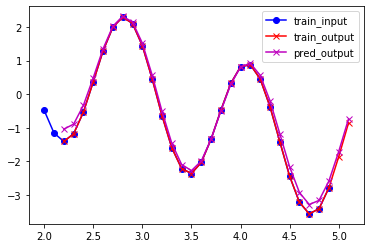

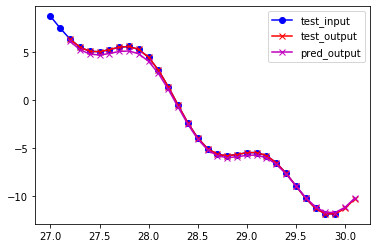

In [0]:
# prediction 
test_index = 12

pred_y_train  = model.predict(x_train[test_index,:,:].reshape((1,model_config['num_steps'],1)))
pred_y_test   = model.predict(x_test[test_index,:,:].reshape((1,model_config['num_steps'],1)))

x_train_reshaped         = x_train[test_index,:,:].reshape((model_config['num_steps']))
y_train_reshaped         = y_train[test_index,:,:].reshape((model_config['num_steps']))
pred_y_train    = pred_y_train.reshape((model_config['num_steps']))

x_test_reshaped           = x_test[test_index,:,:].reshape((model_config['num_steps']))
y_test_reshaped           = y_test[test_index,:,:].reshape((model_config['num_steps']))
pred_y_test     = pred_y_test.reshape((model_config['num_steps']))


print(tx_train.shape)

plt.figure(1)
plt.plot(tx_train[test_index,:],x_train_reshaped ,color='b',marker='o',label='train_input')
plt.plot(ty_train[test_index,:],y_train_reshaped ,color='r',marker='x',label='train_output')
plt.plot(ty_train[test_index,:],pred_y_train,color='m',marker='x',label='pred_output')
plt.legend()

plt.figure(2)
plt.plot(tx_test[test_index,:],x_test_reshaped ,color='b',marker='o',label='test_input')
plt.plot(ty_test[test_index,:],y_test_reshaped ,color='r',marker='x',label='test_output')
plt.plot(ty_test[test_index,:],pred_y_test,color='m',marker='x',label='pred_output')
plt.legend()
plt.show()
